In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np

# Detekce SMS spamu - Pandas + Scikit-Learn demo

## Základní pohled na data

In [2]:
messages = [line.rstrip() for line in open('./data/SMSSpamCollection')]

In [3]:
len(messages)

5574

In [4]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

Data jsou ve formátu TSV - tab separated value

In [5]:
messages = pandas.read_csv('./data/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE, 
                           names=["label", "message"])

In [6]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

přidáme nový sloupec - délku zpráv

In [8]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [9]:
messages.tail()

,label,message,length
5569,spam,This is the 2nd time we have tried 2 contact u...,160
5570,ham,Will ü b going to esplanade fr home?,36
5571,ham,"Pity, * was in mood for that. So...any other s...",57
5572,ham,The guy did some bitching but I acted like i'd...,125
5573,ham,Rofl. Its true to its name,26


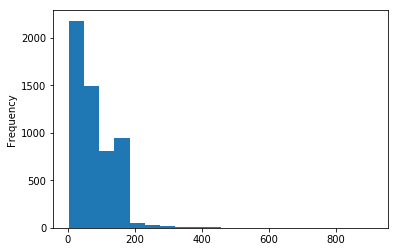

In [10]:
messages.length.plot(bins=20, kind='hist')

In [11]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [12]:
messages[messages.length > 900]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910


In [13]:
messages[messages.length > 900].message

1085    For me the love should start with attraction.i...
Name: message, dtype: object

Je rozdíl v délce zpráv mezi spam a ham SMS?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58552e2dd8>,
      dtype=object)

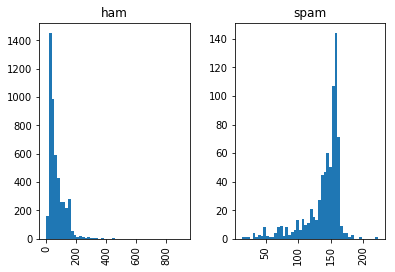

In [84]:
messages.hist(column='length', by='label', bins=50)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5847d40da0>,
      dtype=object)

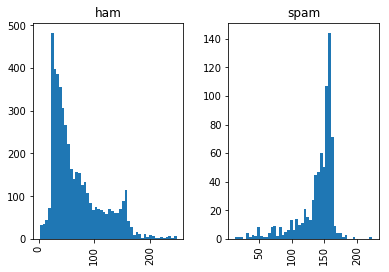

In [85]:
messages[messages.length < 250].hist(column='length', by='label', bins=50)

## Preprocessing

Abychom mohli data zpracovat, musíme text upravit. Zbavíme se stop slov,  převedeme slova na základní tvary. 

A také musíme text převést na číselnou reprezentaci - hledáme matematickou funkci mapující vstup na výstup. To pro slova neumíme. Obvyklou metodou posledních let je tzv. vektorizace textu.

In [15]:
def split_into_tokens(message):
    return TextBlob(message).words

In [16]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

[Lemmatizace](https://cs.wikipedia.org/wiki/Lemmatiz%C3%A1tor) = převedení slov na základní tvar 

In [17]:
def split_into_lemmas(message):
    """
    for each word, take its "base form" = lemma 
    return [word.lemma for word in message]
    """
    words = TextBlob(message).words
    return [word.lemma for word in words]

In [18]:
messages.message.head().apply(split_into_lemmas)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Pro vektorizaci použijeme [BagOfWords](https://en.wikipedia.org/wiki/Bag-of-words_model) model. 

Algoritmus má tři kroky:
* vypočítat frekvenci slov v každé zprávě
* vypočítat inverzní frekvenci slov v dokumentech
* normalizovat vektory

Díky knihovně [Scikit-Learn](http://scikit-learn.org/) ho ale nemusíme implementovat ručně.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])

In [21]:
len(bow_transformer.vocabulary_)

11012

Transformace jedné zprávy vypadá takto:

In [22]:
mes3 = messages['message'][3]

In [23]:
mes3

'U dun say so early hor... U c already then say...'

In [24]:
bow3 = bow_transformer.transform([mes3])

In [25]:
bow3

<1x11012 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [26]:
bow3.shape

(1, 11012)

In [27]:
bow3.nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 4191,  4764,  5365,  6221,  6245,  7139,  9282,  9591, 10056],
       dtype=int32))

In [28]:
print(bow3)

  (0, 4191)	2
  (0, 4764)	1
  (0, 5365)	1
  (0, 6221)	1
  (0, 6245)	1
  (0, 7139)	1
  (0, 9282)	2
  (0, 9591)	1
  (0, 10056)	1


In [29]:
bow3.data

array([2, 1, 1, 1, 1, 1, 2, 1, 1])

Cross check - která slova jsou ve zprávě 2x?

In [30]:
bow_transformer.get_feature_names()[4191]

'U'

In [31]:
bow_transformer.get_feature_names()[9282]

'say'

Tranformace všech zpráv

In [32]:
messages_bow = bow_transformer.transform(messages['message'])

In [33]:
messages_bow

<5574x11012 sparse matrix of type '<class 'numpy.int64'>'
	with 81621 stored elements in Compressed Sparse Row format>

In [34]:
messages_bow.nnz

81621

In [35]:
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparsity: 0.13%


In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

In [37]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [38]:
tfidf3 = tfidf_transformer.transform(bow3)

In [39]:
print(tfidf3)

  (0, 10056)	0.22510385070095637
  (0, 9591)	0.1955442748962185
  (0, 9282)	0.49597495370832545
  (0, 7139)	0.4269339327922034
  (0, 6245)	0.3100112284407115
  (0, 6221)	0.2913528957227454
  (0, 5365)	0.2860779240943588
  (0, 4764)	0.25892595706356525
  (0, 4191)	0.391088549792437


In [40]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]

3.188295946591918

In [41]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

8.527435307660209

In [42]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [43]:
messages_tfidf

<5574x11012 sparse matrix of type '<class 'numpy.float64'>'
	with 81621 stored elements in Compressed Sparse Row format>

## ML Modely - detekce spamu

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 6.96 ms, sys: 3.83 ms, total: 10.8 ms
Wall time: 10.3 ms


In [46]:
print('predicted:', spam_detector.predict(tfidf3)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Jak přesný je náš [Multinomial Naive Bayes](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) klasifikátor?

In [47]:
all_predictions = spam_detector.predict(messages_tfidf)

In [48]:
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [49]:
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(messages['label'], all_predictions))

accuracy 0.9721923214926445


In [50]:
from sklearn.metrics import confusion_matrix
print('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print('(row=expected, col=predicted)')

confusion matrix
 [[4827    0]
 [ 155  592]]
(row=expected, col=predicted)


In [51]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
cfm = confusion_matrix(messages['label'], all_predictions)

Confusion matrix, without normalization
[[4827    0]
 [ 155  592]]


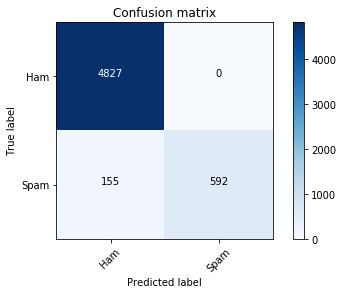

In [53]:
plot_confusion_matrix(cfm, ['Ham', 'Spam'])

Chyba předchozího přístupu je v tom, že používá stejná data pro trénink modelu i pro jeho test. Model se tak může snadno přeučit (overfit) a ztratí schopnost generalizovat a predikovat správné odpovědi pro data, která dosud neviděl. 

Data tedy vždy dělíme na test a train množinu. Někdy dokonce na tři množiny - test, dev a train. Dev je pak test používaný pro vývoj.

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

In [56]:
print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


In [57]:
print(len(messages))

5574


In [58]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [59]:
from sklearn.model_selection import cross_val_score

Pokud máme málo dat je dobré postupně použít všechna dostupná data jak pro trénink, tak pro validaci. Tomuto procesu říkáme "cross validation". Rozdělíme si tedy naše tréninková data znovu - na dev a train set. A to celkem 10x.

In [60]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )

In [61]:
print(scores)

[0.94843049 0.96636771 0.95964126 0.94843049 0.95067265 0.95964126
 0.94618834 0.96412556 0.94618834 0.94382022]


In [62]:
print(scores.mean(), scores.std())

0.953350632337381 0.007833900735609536


In [63]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 150 ms, sys: 8.08 ms, total: 158 ms
Wall time: 12.4 s


<module 'matplotlib.pyplot' from '/home/albert/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

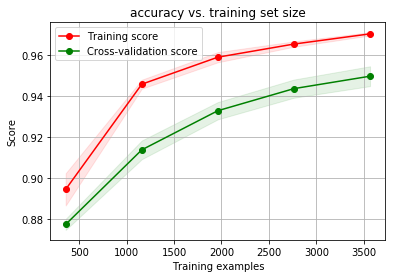

In [64]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

Jak je vidět, model by se učil dál, pokud by dostal více dat. Ty ale nemáme, můžeme ovšem zkusit jiný model, který se učí rychleji. 

### Jak vybrat správný model?


[![](http://scikit-learn.org/stable/_static/ml_map.png)](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False) # what type of cross validation to use
)

In [66]:
%time nb_detector = grid.fit(msg_train, label_train)

CPU times: user 1.71 s, sys: 3.92 ms, total: 1.71 s
Wall time: 15.4 s


In [67]:
print(nb_detector.cv_results_)

{'mean_fit_time': array([2.78642392, 2.78321009, 2.20747538, 1.61732974]), 'std_fit_time': array([0.20925738, 0.08148451, 0.07665537, 0.32129227]), 'mean_score_time': array([0.71098833, 0.65759339, 0.49733534, 0.31113071]), 'std_score_time': array([0.08664645, 0.04711943, 0.01657143, 0.08971907]), 'param_bow__analyzer': masked_array(data=[<function split_into_lemmas at 0x7f585a295e18>,
                   <function split_into_lemmas at 0x7f585a295e18>,
                   <function split_into_tokens at 0x7f585a295488>,
                   <function split_into_tokens at 0x7f585a295488>],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_tfidf__use_idf': masked_array(data=[True, False, True, False],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'bow__analyzer': <function split_into_lemmas at 0x7f585a295e18>, 'tfidf__use_idf': True}, {'bow__analyzer': <function split_into_le

In [68]:
print(nb_detector.best_estimator_)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function split_into_lemmas at 0x7f585a295e18>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocess...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])


In [69]:
print(nb_detector.predict(["Hi mom, how are you?"])[0])

ham


In [70]:
print(nb_detector.predict(["WINNER! FREE Credit!!! Buy Now!"])[0])

spam


In [71]:
predictions = nb_detector.predict(msg_test)

Confusion matrix, without normalization
[[957   0]
 [ 71  87]]


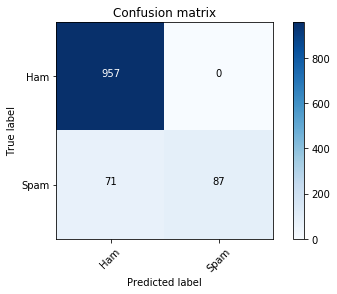

In [72]:
plot_confusion_matrix(confusion_matrix(label_test, predictions), ['Ham', 'Spam'])

## SVM - Support Vector Machines

Velmi efektivní model pro textová data.

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

In [74]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),  # what type of cross validation to use
)

In [75]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

CPU times: user 2.65 s, sys: 8.02 ms, total: 2.66 s
Wall time: 1min


In [76]:
print(svm_detector.best_estimator_)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function split_into_lemmas at 0x7f585a295e18>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocess...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [77]:
print(svm_detector.predict(["Hi mom, how are you?"])[0])

ham


In [78]:
print(svm_detector.predict(["WINNER! FREE credit! Join NOW"])[0])

spam


Confusion matrix, without normalization
[[955   2]
 [ 16 142]]


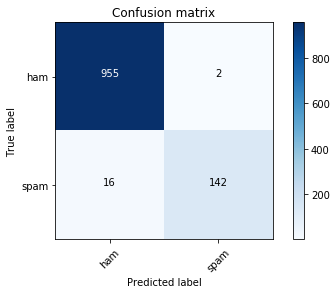

In [79]:
plot_confusion_matrix(confusion_matrix(label_test, svm_detector.predict(msg_test)), ['ham', 'spam'])

In [80]:
from sklearn.metrics import classification_report
print(classification_report(label_test, svm_detector.predict(msg_test)))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       957
        spam       0.99      0.90      0.94       158

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



## Produkční nasazení

Model můžeme uložit pomocí modulu pickle

In [81]:
with open('sms_spam_detector.pkl', 'wb') as fout:
    pickle.dump(svm_detector, fout)

Nahraný model můžeme použít zcela samostatně. Pochopitelně potřebujem data a naimportované příslušné knihovny, takže pro jednoduchost pokračujeme zde.

In [82]:
svm_detector_reloaded = pickle.load(open('sms_spam_detector.pkl', 'rb'))

In [83]:
print(mes3)
print('trénovaný model:', svm_detector.predict([mes3])[0])
print('nahraný model:', svm_detector_reloaded.predict([mes3])[0])

U dun say so early hor... U c already then say...
trénovaný model: ham
nahraný model: ham


@Source - Radim Řehůřek [Practical Data Science in Python](https://radimrehurek.com/data_science_python/)